In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hsql as hsql
import im_v2.ccxt.data.client as icdcl
import im_v2.common.universe as ivcu
import im_v2.im_lib_tasks as imvimlita

/app/amp/helpers/hparquet.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-c37e1643-c548-4e5a-9b69-5649f7dfe19e.json'
INFO  # Git
  branch_name='CmTask3119_Move_DB_delay_analysis_to_a_separate_notebook'
  hash='79ba3b032'
  # Last commits:
    * 79ba3b032 dan      linter                                                            (17 minutes ago) Wed Nov 2 13:39:04 2022  (HEAD -> CmTask3119_Move_DB_delay_analysis_to_a_separate_notebook, origin/CmTask3119_Move_DB_delay_analysis_to_a_separate_notebook)
    * c634a1337 dan      checkpoint                                                        (20 minutes ago) Wed Nov 2 13:36:02 2022           
    * 425887553 dan      CmTask3119: Move DB delay analysis to a separate notebook         (24 minutes ago) Wed Nov 2 13:32:03 2022           
# Machine info
  system=Linux
  node name=5675e4514b2b
  release=5.15.0-1022-aws
  version=#26~20.04.1-Ubuntu SMP Sat Oct 15 03:22:07 UTC 2022
  machine=x86_64
  processo

# Data delay analysis

In [4]:
# Get the real-time `ImClient`.
# TODO(Grisha): ideally we should get the values from the config.
resample_1min = False
env_file = imvimlita.get_db_env_path("dev")
connection_params = hsql.get_connection_info_from_env_file(env_file)
db_connection = hsql.get_connection(*connection_params)
table_name = "ccxt_ohlcv_futures"
#
im_client = icdcl.CcxtSqlRealTimeImClient(
    resample_1min, db_connection, table_name
)

/app/amp/helpers/hsql_implementation.py:550: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [5]:
# Get the universe.
# TODO(Grisha): get the version from the config.
vendor = "CCXT"
mode = "trade"
version = "v7.1"
as_full_symbol = True
full_symbols = ivcu.get_vendor_universe(
    vendor,
    mode,
    version=version,
    as_full_symbol=as_full_symbol,
)
full_symbols

['binance::APE_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::CRV_USDT',
 'binance::CTK_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::DYDX_USDT',
 'binance::ETH_USDT',
 'binance::FTM_USDT',
 'binance::GMT_USDT',
 'binance::LINK_USDT',
 'binance::MATIC_USDT',
 'binance::NEAR_USDT',
 'binance::OGN_USDT',
 'binance::RUNE_USDT',
 'binance::SAND_USDT',
 'binance::SOL_USDT',
 'binance::STORJ_USDT',
 'binance::UNFI_USDT',
 'binance::WAVES_USDT',
 'binance::XRP_USDT']

In [6]:
# Load the data for the reconciliation date.
# `ImClient` operates in UTC timezone.
# TODO(Grisha): ideally we should get the values from the config.
date_str = "2022-10-28"
start_ts = pd.Timestamp(date_str, tz="UTC")
end_ts = start_ts + pd.Timedelta(days=1)
columns = None
filter_data_mode = "assert"
df = im_client.read_data(
    full_symbols, start_ts, end_ts, columns, filter_data_mode
)
hpandas.df_to_str(df, num_rows=5, log_level=logging.INFO)

/app/amp/helpers/hsql_implementation.py:550: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,knowledge_timestamp,open,high,low,close,volume,end_download_timestamp,id,full_symbol
2022-10-28 00:00:00+00:00,2022-10-28 00:01:16.005134+00:00,4.606,4.608,4.605,4.605,21555.0,2022-10-28 00:01:15.501577+00:00,4589919,binance::APE_USDT
2022-10-28 00:00:00+00:00,2022-10-28 00:01:13.781530+00:00,16.88,16.881,16.846,16.848,10808.0,2022-10-28 00:01:13.278411+00:00,4589917,binance::AVAX_USDT
,...,...,...,...,...,...,...,...,...
2022-10-29 00:00:00+00:00,2022-10-29 00:01:32.743001+00:00,3.285,3.286,3.284,3.286,6622.5,2022-10-29 00:01:32.239969+00:00,4628811,binance::WAVES_USDT
2022-10-29 00:00:00+00:00,2022-10-29 00:01:25.212265+00:00,0.474,0.4745,0.4739,0.4741,995562.4,2022-10-29 00:01:24.709140+00:00,4628805,binance::XRP_USDT


<AxesSubplot: title={'center': 'DB delay in seconds per asset'}, xlabel='full_symbol'>

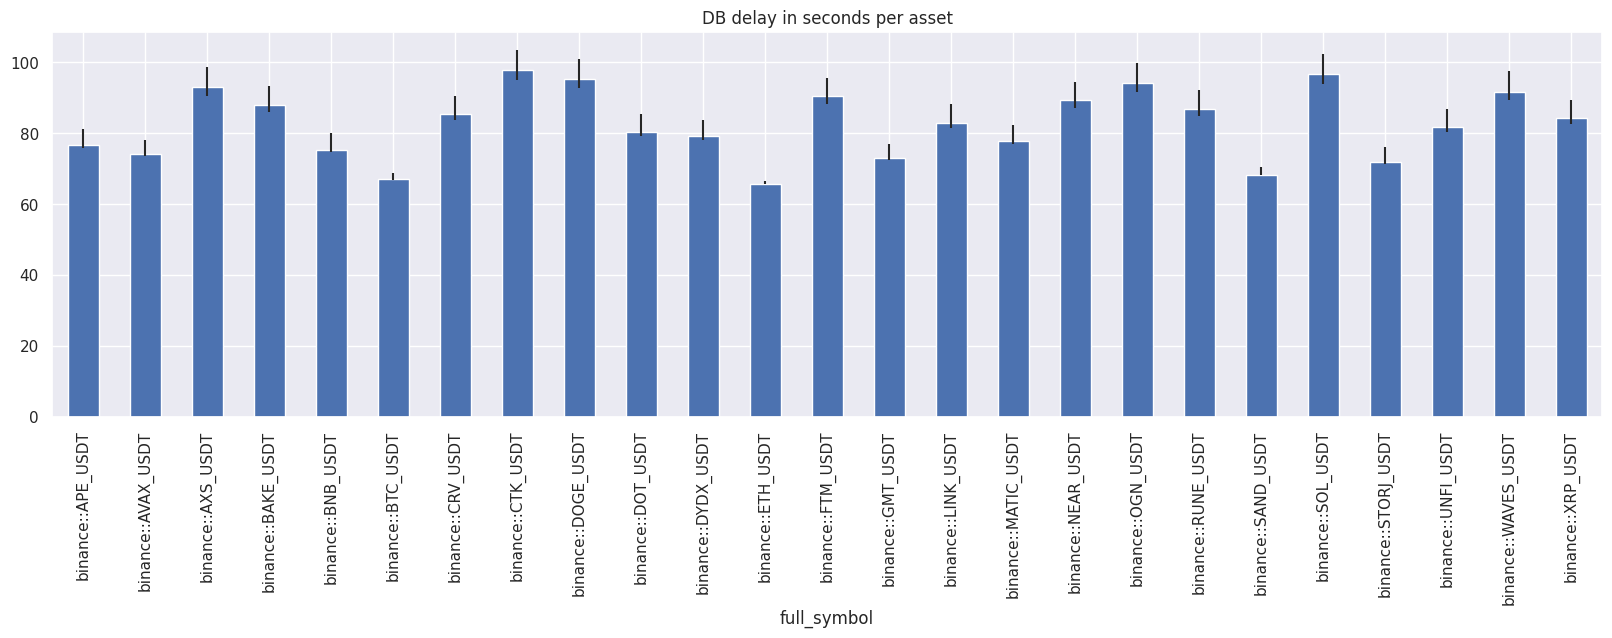

In [7]:
# TODO(Grisha): move to a lib.
# Compute delay in seconds.
df["delta"] = (df["knowledge_timestamp"] - df.index).dt.total_seconds()
# Plot the delay over assets with the errors bars.
delta_per_asset = df.groupby(by=["full_symbol"])["delta"]
minimums = delta_per_asset.min()
maximums = delta_per_asset.max()
means = delta_per_asset.mean()
errors = [means - minimums, maximums - means]
# TODO(Grisha): sort by maximum delay.
means.plot(kind="bar", yerr=errors, title="DB delay in seconds per asset")